## 영화 제목 입력 및 url 인코딩

In [7]:
from urllib.parse import quote

title = input("영화 제목 입력:")
print(title, type(title))
con_title = title + ' 평점'

encoded_naver_title = quote(con_title)
encoded_daum_title = quote(title)

naver_url = "https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=0&ie=utf8&query="+encoded_naver_title
print(naver_url)
daum_url="https://movie.daum.net/search?q="+encoded_daum_title+'#tab=all'
print(daum_url)

영화 제목 입력:겨울왕국
겨울왕국 <class 'str'>
https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=0&ie=utf8&query=%EA%B2%A8%EC%9A%B8%EC%99%95%EA%B5%AD%20%ED%8F%89%EC%A0%90
https://movie.daum.net/search?q=%EA%B2%A8%EC%9A%B8%EC%99%95%EA%B5%AD#tab=all


## 네이버영화 크롤링

In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time
import pandas as pd

driver = webdriver.Chrome('C:/Users/MinUk/crawling/chromedriver.exe')

driver.get(naver_url)
time.sleep(5)

# 리뷰 영역 클릭
area_element = driver.find_element(By.CLASS_NAME, 'area_card_outer')
area_element.click()
time.sleep(3)  # Wait for content to load (adjust as needed)

# 스크롤 영역 탐색
scrollable_element = driver.find_element(By.CLASS_NAME, 'lego_review_list')

# 스크롤 끝까지 내려갈때까지 내리기
last_height = driver.execute_script("return arguments[0].scrollHeight;", scrollable_element)
while True:
    driver.execute_script("arguments[0].scrollTo(0, arguments[0].scrollHeight);", scrollable_element)
    time.sleep(3)  # 다 내려갈때까지 기다려야함
    
    new_height = driver.execute_script("return arguments[0].scrollHeight;", scrollable_element)
    if new_height == last_height:
        break
    last_height = new_height

page_source = driver.page_source
driver.quit()

soup = BeautifulSoup(page_source, 'html.parser')

review_items = soup.find_all('li', class_='area_card _item')

# 리뷰 데이터
reviews_data = []

for review in review_items:
    #리뷰 내용
    report_title = review['data-report-title']
    
    # 평점 데이터
    rating_value = review.find('div', class_='area_text_box').text.strip()[-1]
    
    reviews_data.append({
        "Report Title": report_title,
        "Rating": rating_value
    })

# 결과 저장 데이터프레임
df = pd.DataFrame(reviews_data)
df

C:\Users\MINUK\AppData\Local\Temp\ipykernel_9224\1761216325.py:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('C:/Users/MinUk/crawling/chromedriver.exe')


,Report Title,Rating
0,작화가 훌륭한만큼 내용은 아쉽다,6
1,마지막에 나오는 ost가 좋았고 와라와라가 귀여웠습니다. 솔직히 무슨 내용인지는 짐...,8
2,초반엔 좀 지루했는데 점점 이야기가 몰아친다.,8
3,30년대 군수공장 아들얘기 ㅎ....다 떠나서 재미가 없어요...,2
4,거장의 내면 토크 : 불친절해졌지만 행복했다,9
...,...,...
305,하울이나 센과치히로 기대하고 보면 대 실망,4
306,말이 필요없는 미야자키의 은퇴작이자 명작,0
307,좋은 장면들도 있었으나 지브리 영화 중 인상적이진 못한거같음,7
308,두 번 봤다. 이해하기 어렵지만 아름다운 애니메이션.,8


## 다음 영화 크롤링

In [25]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time
import pandas as pd


driver = webdriver.Chrome('C:/Users/MinUk/crawling/chromedriver.exe')

driver.get(daum_url)
time.sleep(5)

# button_tomovie_xpath = '//*[@id="mainContent"]/div/div[2]/div[2]/ul/li/div/div/strong/a'
# button_tomovie_element = driver.find_element("xpath",button_tomovie_xpath)
first_element = driver.find_element_by_class_name('tit_item').find_element_by_tag_name('a')
first_element.click()
time.sleep(3)
button_grade_xpath = '//*[@id="mainContent"]/div/div[2]/div[1]/ul/li[4]/a/span'
button_grade_element = driver.find_element("xpath",button_grade_xpath)
button_grade_element.click()
time.sleep(3)

click_count = 0  # 클릭한 횟수를 저장할 변수

while True:
    try:
        # '더보기' 버튼 찾기
        more_button = driver.find_element("xpath", '//*[@id="alex-area"]/div/div/div/div[3]/div[1]/button/span[2]')

        # 버튼 클릭
        more_button.click()

        # 클릭 횟수 증가
        click_count += 1

        # 클릭 후 3초간 대기 (필요에 따라 조절)
        time.sleep(3)

        # 30번 클릭하면 종료
        if click_count >= 30:
            print("Clicked 20 times. Exiting the loop.")
            break

    except Exception as e:
        print(f"Failed to find '더보기' button. Exiting the loop.")
        break

daum_page_source = driver.page_source
# 드라이버 종료
driver.quit()

soup = BeautifulSoup(daum_page_source, 'html.parser')

reviews = soup.find_all('p', class_='desc_txt')

review_texts = [review.get_text(strip=True) for review in reviews]


reviews_data = []
# 추출된 리뷰 텍스트 출력
for text in review_texts:
    reviews_data.append(text)
    
df = pd.DataFrame(reviews_data,columns=['Review'])
df


Failed to find '더보기' button. Exiting the loop.


,Review
0,.
1,여태까지 본 영화 중에 황당할 만큼 재미없고 지루한 영화!\n졸아도 졸아도 끝나지 ...
2,미야자키 하야오가 만든 작품 중 가장 예술적인 부분을 강조한 듯. 가장 사랑하는 그...
3,밑에 얘 조국 중국영화는 10점 주고 일본영화는 죄다 테러하는 조선족ㅋㅋㅋㅋㅋㅋ
4,이걸 왜보는거지?\n친일매국노 윤석열정부다보니 일어가 듣고싶은거야?\n매국노들이 판...
...,...
283,꼭 보고싶다 빨리 개봉해라..
284,무거운 분위기의 스토리와 걸맞지않는 귀여운것도 나와요! (•0•) ㅋㅋㅋ 할머니들도...
285,한국개봉일도 7/14로 해주세요 계속 기다리고 있어요
286,그저고트....


# 영화 제목 입력 ->네이버와 다음 영화 모두 크롤링(최종본)

In [92]:
import time
import pandas as pd
from urllib.parse import quote
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup


title = input("영화 제목 입력:")
print(title, type(title))
con_title = title + ' 평점'

encoded_naver_title = quote(con_title)
encoded_daum_title = quote(title)

naver_url = "https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=0&ie=utf8&query="+encoded_naver_title
print(naver_url)
daum_url="https://movie.daum.net/search?q="+encoded_daum_title+'#tab=all'
print(daum_url)

영화 제목 입력:그대들은 어떻게 살 것인가
그대들은 어떻게 살 것인가 <class 'str'>
https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=0&ie=utf8&query=%EA%B7%B8%EB%8C%80%EB%93%A4%EC%9D%80%20%EC%96%B4%EB%96%BB%EA%B2%8C%20%EC%82%B4%20%EA%B2%83%EC%9D%B8%EA%B0%80%20%ED%8F%89%EC%A0%90
https://movie.daum.net/search?q=%EA%B7%B8%EB%8C%80%EB%93%A4%EC%9D%80%20%EC%96%B4%EB%96%BB%EA%B2%8C%20%EC%82%B4%20%EA%B2%83%EC%9D%B8%EA%B0%80#tab=all


In [93]:
driver = webdriver.Chrome('C:/Users/MinUk/crawling/chromedriver.exe')

driver.get(naver_url)
time.sleep(5)

# 리뷰 영역 클릭
area_element = driver.find_element(By.CLASS_NAME, 'area_card_outer')
area_element.click()
time.sleep(3)  # Wait for content to load (adjust as needed)

# 스크롤 영역 탐색
scrollable_element = driver.find_element(By.CLASS_NAME, 'lego_review_list')

# 스크롤 끝까지 내려갈때까지 내리기
last_height = driver.execute_script("return arguments[0].scrollHeight;", scrollable_element)
while True:
    driver.execute_script("arguments[0].scrollTo(0, arguments[0].scrollHeight);", scrollable_element)
    time.sleep(3)  # 다 내려갈때까지 기다려야함
    
    new_height = driver.execute_script("return arguments[0].scrollHeight;", scrollable_element)
    if new_height == last_height:
        break
    last_height = new_height

naver_page_source = driver.page_source
driver.quit()

soup = BeautifulSoup(naver_page_source, 'html.parser')

review_items = soup.find_all('li', class_='area_card _item')

# 리뷰 데이터
reviews_data = []

for review in review_items:
    #리뷰 내용
    report_title = review['data-report-title']
    
    reviews_data.append(report_title)
    
driver = webdriver.Chrome('C:/Users/MinUk/crawling/chromedriver.exe')

driver.get(daum_url)
time.sleep(5)

first_element = driver.find_element_by_class_name('tit_item').find_element_by_tag_name('a')
first_element.click()
time.sleep(3)
button_grade_xpath = '//*[@id="mainContent"]/div/div[2]/div[1]/ul/li[4]/a/span'
button_grade_element = driver.find_element("xpath",button_grade_xpath)
button_grade_element.click()
time.sleep(3)

click_count = 0  # 클릭한 횟수를 저장할 변수

while True:
    try:
        # '더보기' 버튼 찾기
        more_button = driver.find_element("xpath", '//*[@id="alex-area"]/div/div/div/div[3]/div[1]/button/span[2]')

        # 버튼 클릭
        more_button.click()

        # 클릭 횟수 증가
        click_count += 1

        # 클릭 후 3초간 대기 (필요에 따라 조절)
        time.sleep(3)

        # 30번 클릭하면 종료
        if click_count >= 30:
            print("Clicked 30 times. 탐색 완료.")
            break

    except Exception as e:
        print(f"전부 탐색 완료")
        break

daum_page_source = driver.page_source
# 드라이버 종료
driver.quit()

soup = BeautifulSoup(daum_page_source, 'html.parser')

reviews = soup.find_all('p', class_='desc_txt')

review_texts = [review.get_text(strip=True) for review in reviews]

# 추출된 리뷰 텍스트 출력
for text in review_texts:
    reviews_data.append(text)

# 결과 저장 데이터프레임
df = pd.DataFrame(reviews_data, columns =['Review'])
df


전부 탐색 완료


,Review
0,"미야자키의 인생을 담은, 모든것을 갈아넣은 작품"
1,그냥 그랬네요 이 영화는 유독 관객 매너도 떨어지고 여러모로 짜증났던 하루였음
2,영상미만으로도 볼 가치는 있다
3,이름있는 감독님 영화라 뭔가 심오해요.
4,작화가 훌륭한만큼 내용은 아쉽다
...,...
593,꼭 보고싶다 빨리 개봉해라..
594,무거운 분위기의 스토리와 걸맞지않는 귀여운것도 나와요! (•0•) ㅋㅋㅋ 할머니들도...
595,한국개봉일도 7/14로 해주세요 계속 기다리고 있어요
596,그저고트....


In [94]:
review_df = df
review_df

,Review
0,"미야자키의 인생을 담은, 모든것을 갈아넣은 작품"
1,그냥 그랬네요 이 영화는 유독 관객 매너도 떨어지고 여러모로 짜증났던 하루였음
2,영상미만으로도 볼 가치는 있다
3,이름있는 감독님 영화라 뭔가 심오해요.
4,작화가 훌륭한만큼 내용은 아쉽다
...,...
593,꼭 보고싶다 빨리 개봉해라..
594,무거운 분위기의 스토리와 걸맞지않는 귀여운것도 나와요! (•0•) ㅋㅋㅋ 할머니들도...
595,한국개봉일도 7/14로 해주세요 계속 기다리고 있어요
596,그저고트....


In [95]:
from transformers import BertForSequenceClassification, BertTokenizer

# 모델 로드
loaded_model = BertForSequenceClassification.from_pretrained('movie_sentiment_model')
loaded_tokenizer = BertTokenizer.from_pretrained('movie_sentiment_tokenizer')

In [51]:
import torch

test_review = df['Review'].tolist()
positive_review = []
negative_review = []

for review in test_review:
    # Assuming loaded_tokenizer is a function that tokenizes the review text
    inputs = loaded_tokenizer(review, return_tensors="pt", truncation=True, max_length=512)
    
    # Assuming loaded_model is a PyTorch model
    outputs = loaded_model(**inputs)
    
    predictions = torch.argmax(outputs.logits, dim=1).item()
    if predictions == 1:
        positive_review.append(review)
    else:
        negative_review.append(review)


# Creating DataFrames
positive_df = pd.DataFrame({'Positive Review': positive_review})
negative_df = pd.DataFrame({'Negative Review': negative_review})


In [96]:
review_df['Review']=review_df['Review'].str.replace('\n', '')

In [97]:
import pandas as pd
import kss  # Korean Sentence Splitter

# 각 리뷰를 문장 단위로 분리 (Korean Sentence Splitter 사용)
review_df['Review'] = review_df['Review'].apply(lambda x: kss.split_sentences(x))

# explode 함수를 사용하여 각 문장을 다른 row로 분리
df_exploded = df.explode('Review').reset_index(drop=True)
# 결과 출력
print(df_exploded)


                                   Review
0              미야자키의 인생을 담은, 모든것을 갈아넣은 작품
1                                 그냥 그랬네요
2     이 영화는 유독 관객 매너도 떨어지고 여러모로 짜증났던 하루였음
3                        영상미만으로도 볼 가치는 있다
4                   이름있는 감독님 영화라 뭔가 심오해요.
...                                   ...
1252        (•0•) ㅋㅋㅋ 할머니들도 너무 귀여웠습니다ㅋㅋㅋㅋ
1253                    한국개봉일도 7/14로 해주세요
1254                         계속 기다리고  있어요
1255                             그저고트....
1256                       개꿀잼 엳시  킹갓 제네럴

[1257 rows x 1 columns]


In [98]:
df_exploded

,Review
0,"미야자키의 인생을 담은, 모든것을 갈아넣은 작품"
1,그냥 그랬네요
2,이 영화는 유독 관객 매너도 떨어지고 여러모로 짜증났던 하루였음
3,영상미만으로도 볼 가치는 있다
4,이름있는 감독님 영화라 뭔가 심오해요.
...,...
1252,(•0•) ㅋㅋㅋ 할머니들도 너무 귀여웠습니다ㅋㅋㅋㅋ
1253,한국개봉일도 7/14로 해주세요
1254,계속 기다리고 있어요
1255,그저고트....


Optimal number of clusters: 22


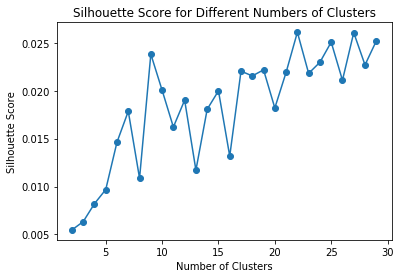

Cluster 1 - Representative Review: 우리는 그 나이에 뭘 하고 있을까?
Other Reviews in the Cluster:
94                                   우리는 그 나이에 뭘 하고 있을까?
95                                  우리는 지금 그래서 뭘 하고 있을까?
240    그의 모든 작품을 관통하는 메세지의 원천을 들여다볼 수 있는 자전적인 회고록임과 동...
332                               곁에 있는 모든 것에 감사하며 살겠습니다
820                         사랑과 희망 그리고 우리는 서로 보듬고 살겠습니다.
Name: Review, dtype: object


Cluster 2 - Representative Review: 꿈과 같은 영화.
Other Reviews in the Cluster:
36      처제와의 재혼 및 임신인 거 알자마자 바로 비위 상해서 영화 내용은 머리에 들어오지...
76                                미야자키 하야오만 알 수 있는 특이한 영화
135                                             꿈과 같은 영화.
168     이 세상은 유한하고 다른 차원이 있음을 보여줌으로써 눈에 보이는 것만 쫓는 세태에 ...
173                 현실에 주저하지 말고 어떻해서든 살아가야 한다는 메세지를 담은 영화
200                                      하야오만이 만들 수 잇는 영화
215                                             꿈같은 영화...
222                                    호불호 갈릴 수 밖에 없는 영화.
246                              호기심에 본 영화 끝까지 물음표만 남네요..
264

In [111]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

reviews = df_exploded['Review'].dropna()

# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(reviews)

# 시도할 클러스터 개수의 범위
cluster_range = range(2, min(len(reviews), 30))

# 클러스터 개수에 따른 Silhouette score 저장
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

# 최적 클러스터 개수 선택
optimal_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]

# 결과 출력
print(f"Optimal number of clusters: {optimal_clusters}")

# Silhouette score 시각화
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.show()

# 선택된 최적 클러스터 개수로 K-means 모델 훈련
num_clusters = optimal_clusters
kmeans = KMeans(n_clusters=optimal_clusters)
kmeans.fit(X)
labels = kmeans.labels_

# 각 클러스터의 중심 문장 출력
for i in range(num_clusters):
    cluster_indices = np.where(labels == i)[0]
    
    # 클러스터에 속한 리뷰가 없을 경우 건너뛰기
    if len(cluster_indices) == 0:
        continue
    
    # 클러스터 중심과의 코사인 유사도 계산
    cluster_center = kmeans.cluster_centers_[i].reshape(1, -1)
    similarities = cosine_similarity(X[cluster_indices], cluster_center)
    
    # 가장 높은 유사도를 가진 문장 선택
    representative_review_index = cluster_indices[np.argmax(similarities)]
    representative_review = reviews.iloc[representative_review_index]
    
    print(f"Cluster {i+1} - Representative Review: {representative_review}")
    print("Other Reviews in the Cluster:")
    print(reviews.iloc[cluster_indices])
    print("\n")
